In [12]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager
# from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# Other
import datetime
import os
from tqdm import tqdm
from pathlib import Path
from os import listdir
from skimage.metrics import structural_similarity as ssim
# from fastaniso import anisodiff
# from time import time
from IPython.display import clear_output

# Graphics
from matplotlib import pyplot as plt
import seaborn as sns

# Additional modules
# from dataset_creator import generate_csv
# from assistive_funcs import filtering_image, check_ssim, convert_to_grayscale, get_dataset_name
# from csv_dataloader import get_train_test_data
from math import floor

In [13]:
# Paths
p_main_data = Path("../data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files" # datasets_path
p_img = p_main_data / "images"

p_noised_imgs = p_main_data / "imgs_with_noise" 

p_filtered_images = p_main_data / "filtered_imgs"

p_gray_images = p_main_data / "gray_images"

# Dataset
win_size = 7
_step = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device = }")

device = device(type='cpu')


In [14]:
def add_noise(img, scale=0.2707) -> np.array:

    # Create noise
    size = img.shape
    noise = np.random.rayleigh(scale=scale, size=size)
    # Add noise
    noised_img = img + img * noise
    noised_img = np.where(noised_img <= 255, noised_img, 255)
    return torch.Tensor(noised_img)

In [15]:
def load_data(w, h, test_size=0.2, batch_size=32):

    transform = transforms.Compose([
        transforms.Resize(size=(w, h)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        # transforms.Lambda(lambd=lambda x: x * 255)
    ])
        # transforms.Normalize((0.5,), (0.5,)),
        # transforms.Lambda(lambd=lambda x: x / 255),
    
    Data = datasets.ImageFolder(p_main_data / "images_for_cnn", transform=transform)


    num_data = len(Data)
    indices_data = list(range(num_data))
    np.random.shuffle(indices_data)
    split_tt = int(np.floor(test_size * num_data))
    train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(Data, sampler=train_sampler, batch_size=batch_size)  # num_workers=4
    testloader = torch.utils.data.DataLoader(Data, sampler=test_sampler,  batch_size=batch_size)  # num_workers=4

    return trainloader, testloader

In [16]:
w, h = 608, 608
batch_size = 1
test_size = 0.2
trainloader, testloader = load_data(w, h, test_size=test_size, batch_size=batch_size)

for image in testloader:
    print(image)
    image = image[0].squeeze()
    print(image)
    break

[tensor([[[[0.2627, 0.2706, 0.2745,  ..., 0.6235, 0.6118, 0.5882],
          [0.2667, 0.2784, 0.2824,  ..., 0.6157, 0.6078, 0.5961],
          [0.2706, 0.2824, 0.2863,  ..., 0.6157, 0.6118, 0.6118],
          ...,
          [0.4549, 0.4039, 0.4000,  ..., 0.2118, 0.2314, 0.2471],
          [0.4667, 0.4078, 0.4118,  ..., 0.2000, 0.2314, 0.2549],
          [0.5216, 0.4784, 0.4863,  ..., 0.2471, 0.2784, 0.2667]]]]), tensor([0])]
tensor([[0.2627, 0.2706, 0.2745,  ..., 0.6235, 0.6118, 0.5882],
        [0.2667, 0.2784, 0.2824,  ..., 0.6157, 0.6078, 0.5961],
        [0.2706, 0.2824, 0.2863,  ..., 0.6157, 0.6118, 0.6118],
        ...,
        [0.4549, 0.4039, 0.4000,  ..., 0.2118, 0.2314, 0.2471],
        [0.4667, 0.4078, 0.4118,  ..., 0.2000, 0.2314, 0.2549],
        [0.5216, 0.4784, 0.4863,  ..., 0.2471, 0.2784, 0.2667]])


In [17]:
class CNNModel(nn.Module):
    def __init__(self, *, num_filter=64, num_channel=1, kernel_size=5, padding=1) -> None:
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(1, num_filter, kernel_size, padding=1),
            nn.BatchNorm2d(num_filter),
            nn.ReLU(),
            
            nn.Conv2d(num_filter, num_filter, kernel_size, padding=1),
            nn.BatchNorm2d(num_filter),
            nn.ReLU(),
            
            nn.Conv2d(num_filter, num_filter, kernel_size, padding=1),
            nn.BatchNorm2d(num_filter),
            nn.ReLU(),
            
            nn.Conv2d(num_filter, num_filter, kernel_size, padding=1),
            nn.BatchNorm2d(num_filter),
            nn.ReLU(),
            
            nn.Conv2d(num_filter, num_filter, kernel_size, padding=1),
            nn.BatchNorm2d(num_filter),
            nn.ReLU(),
            
            nn.Conv2d(num_filter, num_channel, kernel_size, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )
    def forward(self, x):        
        return self.sequential(x)

In [18]:
num_filter = 128
num_channel = 1
kernel_size = 3
learning_rate = 0.001
padding = 1

model = CNNModel(num_filter=num_filter, num_channel=num_channel, kernel_size=kernel_size, padding=padding)

loss_metric = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


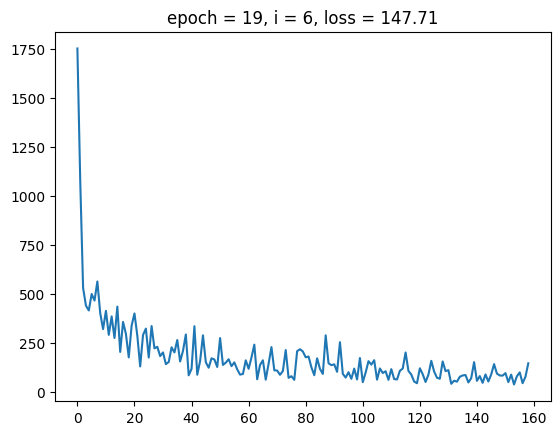

KeyboardInterrupt: 

In [19]:
EPOCHS = 40
losses = []

for epoch in range(EPOCHS):
    for i, image in enumerate(trainloader):
        image = image[0].squeeze() * 255
        
        optimizer.zero_grad()
        
        noised_image = add_noise(image)
        
        predicted_noise = model(noised_image[None, None])
        out_image = noised_image / (1 + predicted_noise).squeeze()
        loss = loss_metric(out_image, image)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        clear_output()
        plt.plot(losses)
        plt.title(f"{epoch = }, {i = }, loss = {loss.item():.2f}")
        plt.show()

In [ ]:
# torch.save(model, p_models / "conv_model.pt")
# torch.save(model.state_dict(), p_models / "conv_model_state_dict.pt")

In [ ]:
# model = torch.load(p_models / "conv_model.pt")

Statistics: mean = 0.10517542064189911, std = 0.1512717604637146 

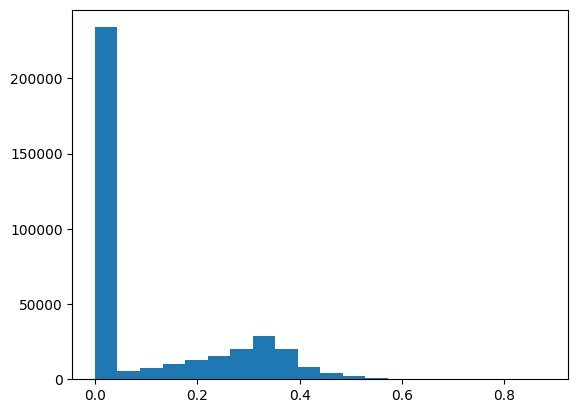

SSIM = 0.393


In [21]:
def evaluate():
    with torch.no_grad():
        model.eval()
        for i, image in enumerate(testloader):
            image = image[0].squeeze() * 255
            Image.fromarray(image.numpy()).show(title="Genuine image")
            
            noised_image = add_noise(image)
            Image.fromarray(noised_image.numpy()).show(title="Noised image")
            
            predicted_noise = model(image[None, None]).squeeze()
            print(f"Statistics: mean = {predicted_noise.mean()}, std = {predicted_noise.std()} ", end="")
            plt.hist(predicted_noise.squeeze().numpy().flatten(), bins=20, )
            plt.show()
            
            out_image = noised_image / (1 + predicted_noise)
            Image.fromarray(out_image.numpy()).show(title="Filtered image")
            
            filtered_img = out_image.numpy()
            genuine_img = image.numpy()
            ssim_metric = ssim(filtered_img, genuine_img)
            print(f"SSIM = {ssim_metric:.3f}")
            
            return 
        
evaluate()